In [93]:
import os
import json

from dotenv import load_dotenv

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama import ChatOllama
from typing import Annotated, TypedDict, Literal

from langgraph.graph.message import add_messages
from langgraph.graph import END
from langchain_core.messages.ai import AIMessage
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.system import SystemMessage
from langchain_community.tools import DuckDuckGoSearchResults
from pydantic import BaseModel, Field


from langchain_unstructured import UnstructuredLoader
from langchain_community.vectorstores import SQLiteVec
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.prompts import PromptTemplate

from langgraph.graph import StateGraph, START

from IPython.display import Image, Markdown

In [94]:
load_dotenv()


GOOGLEAPI = os.getenv("GOOGLEAPI")
os.environ["GOOGLE_API_KEY"] = GOOGLEAPI

GOOGLE= ChatGoogleGenerativeAI(
    # temperature=0,
    model="gemini-2.0-flash",
    # max_tokens=300,
    # top_p=0.95,
    # top_k=40,
    # streaming=True,
)

OLLAMA = ChatOllama(
    model="llama3.2:3b",
    temperature=0,
    streaming=True,
)

OLLAMAJSON = ChatOllama(
    model="llama3.2:3b",
    temperature=0,
    format="json",
    streaming=True,
)


In [95]:
llm = OLLAMA
llm_json = OLLAMAJSON

#llm.invoke("What is python?")

In [96]:
search = DuckDuckGoSearchResults(output_format="json")

In [97]:
json.loads(search.invoke("Who is a PEP?"))[0]["snippet"]

'Government-issued PEP lists. Countries sometimes publish lists of domestic PEPs or prominent public functions. This is not required by the FATF standards, however, and such lists have potential shortcomings and might pose challenges for effective implementation.. Countries might publish two types of list: (1) a list of positions/functions that would be held by a PEP, or (2) a list of names of ...'

In [98]:
class Router(BaseModel):
    """
    A simple router to route between states.
    """
    step: Literal["audit_assistant", "websearch", "vectorstore"] = Field(None, description="The step to route to")

In [99]:
connection = SQLiteVec.create_connection(db_file="policies.db")

EMBEDDINGS = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [100]:
def retriever(query: str) -> list[str]:

    """
    Call the retriever tool to get the policy
    """
    vector_db = SQLiteVec(table="policy", embedding=EMBEDDINGS, connection=connection)

    QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""
    Your task is to generate five different versions
    of the given user question to retrieve relevant documents from a vector database.
    By generating multiple perspectives on the user question, your goal is to help the user
    overcome some of the limitations of the distance-based similarity search.
    Provide alternative questions seperated by new lines.
    Original question: {question}""",

    )

    # retriever = MultiQueryRetriever.from_llm(
    #                 retriever=vector_db.as_retriever(),
    #                 llm=OLLAMA,
    #                 prompt=QUERY_PROMPT,
    #                 parser_key="lines"
    #                 )

    retriever = vector_db.as_retriever()
    docs = retriever.invoke(query)

    return docs

In [101]:
retriever("What is AML CFT?")

[Document(metadata={'source': 'C:\\Users\\aeniatorudabo\\Documents\\7.3 - AML CFT CPF Policy.pdf', 'coordinates': {'points': [[89.088, 191.44999999999993], [89.088, 203.44999999999993], [224.11599999999999, 203.44999999999993], [224.11599999999999, 191.44999999999993]], 'system': 'PixelSpace', 'layout_width': 595.2, 'layout_height': 841.92}, 'file_directory': 'C:\\Users\\aeniatorudabo\\Documents', 'filename': '7.3 - AML CFT CPF Policy.pdf', 'languages': ['eng'], 'last_modified': '2024-11-20T10:18:40', 'page_number': 121, 'filetype': 'application/pdf', 'category': 'Title', 'element_id': 'cdb79991f33ea7a2e4924045042e2c67'}, page_content='with respect to AML/CFT/CFT.'),
 Document(metadata={'source': 'C:\\Users\\aeniatorudabo\\Documents\\7.3 - AML CFT CPF Policy.pdf', 'coordinates': {'points': [[57.624, 197.68999999999994], [57.624, 209.68999999999994], [173.68599999999998, 209.68999999999994], [173.68599999999998, 197.68999999999994]], 'system': 'PixelSpace', 'layout_width': 595.2, 'layou

In [102]:
route_prompt = """You are a router to route to the audit assistant, vectorstore or websearch based on the question asked.
                   The vectorsore contains documents on AML CFT, PEP, KYC and other policies.
                   Use the vectorstore for questions on these topics.
                   For current events, use the websearch
                   For questions on the audits, use audit_assistant.
                   Return the step to route to as a json object with the key 'step'"""

In [103]:
response = llm_json.invoke(
    [SystemMessage(route_prompt),
    HumanMessage("Who is a PEP?")
    ]
)

json.loads(response.content)

{'step': 'vectorstore'}

In [104]:
document_grader_instructions = """
    You are a document grader. You will be given a question and a document.
    Your task is to grade the document based on the question asked.
    if the documemnt contains keywords or semantic meaning related to the question, return a score of 1.
    else return a score of 0."""

document_grader_prompt = """
Here is the retrieved document \n\n{document}\n\n
Here is the question asked \n\n{question}\n\n
Think carefully about it and return a json object with the key 'score' and the value 1 or 0 based on the document and question
to indicate if the document is relevant to the question asked."""

question = "What is a PEP?"
documents = retriever("Who is a PEP?")

for document in documents:
    
    response = llm_json.invoke(
        [SystemMessage(document_grader_instructions),
        HumanMessage(document_grader_prompt.format(document=document.page_content, question=question))
        ]
    )

    print(json.loads(response.content))

{'score': 1}
{'score': 1}
{'score': 1}
{'score': 1}


In [105]:
document.page_content

'Finally any account(s) opened by any person who qualifies as a “PEP” will be designated a “PEP” account.'

In [106]:
rag_prompt = """
You are an assistant that answers questions based on the context provided
here is the context \n\n{context}\n\n

Think carefully about the above context and answer the question asked below.

Here is the question asked \n\n{question}\n\n

Ansqwe the question using only the context provided above.
Be honest and do not make up any information."""

def format_docs(docs: list[str]) -> str:
    """
    Format the documents to be used in the prompt.
    """
    return "\n\n".join([doc.page_content for doc in docs])

response = llm.invoke(
    [HumanMessage(rag_prompt.format(context=format_docs(documents), question=question))]
)

print(response.content)



Based on the context provided, a PEP (Politically Exposed Person) is an individual who is or has been entrusted with prominent public functions in Nigeria or elsewhere.


In [107]:
hallucination_instructions = """
    You are a response grader.
    You will be given a response and a context for the response.
    Your task is to grade the response based on the context provided.
    If the response is correct and based on the context, return a score of 1.
    else return a score of 0.
    Explain the reasoning for your answer step by step.
    Do not state the answer from the onset.
    """


hallucination_prompt = """
Here is the context \n\n{context}\n\n 
Here is the response \n\n{response}\n\n
return a json object with the key 'score' and the value 1 or 0 based on the response and context
to indicate if the response is relevant to the context provided.
return a key 'reasoning' with the value of your reasoning for the score given."""

hallucination_score = llm_json.invoke(
    [SystemMessage(hallucination_instructions),
    HumanMessage(hallucination_prompt.format(context=format_docs(documents), response=response.content))
    ]
)

json.loads(hallucination_score.content)

{'score': 1,
 'reasoning': "The response accurately defines a PEP (Politically Exposed Person) as an individual who has been entrusted with prominent public functions, which aligns with the context provided. The only minor deviation is that the context mentions 'Nigeria or elsewhere', but the response still conveys the correct definition of a PEP."}

In [108]:
response_instructions = """
    You are a response grader.
    You will be given a response and the questuion the response asnwers.
    Your task is to grade the response based on the question asked.
    If the response is correct and based on the question, return a score of 1.
    else return a score of 0.
    Explain the reasoning for your answer step by step.
    Do not state the answer from the onset.
    """

response_prompt = """
Here is the question asked \n\n{question}\n\n
Here is the response \n\n{response}\n\n
return a json object with the key 'score' and the value 1 or 0 based on the response and question
to indicate if the response is relevant to the question asked.
return a key 'reasoning' with the value of your reasoning for the score given."""

response_score = llm_json.invoke(
    [SystemMessage(response_instructions),
    HumanMessage(response_prompt.format(question=question, response=response.content))
    ]
)

json.loads(response_score.content)

{'score': 1,
 'reasoning': 'The response correctly identifies PEP as an acronym for Politically Exposed Person, and provides a clear definition that aligns with the context provided in the question. The definition specifically mentions Nigeria, which is consistent with the common usage of the term in international contexts.'}

In [ ]:
vector_db = SQLiteVec(table="policy", embedding=EMBEDDINGS, connection=connection)
retriever = vector_db.as_retriever()

SYS_PROMPT = (
    "system",
    "You are a helpful assistant to help the internal audit staff achieve their goals"
    "Auditors will come to you with questions about the audit process that should be tested for an audit"
    "You will answer them to the best of your ability and give reasons for your answers"
    "They will also ask you aabout the bank's policies, you will answer by retrieving the policy from a vector database"
    "If you don't know the answer, say 'I don't know'"
    "You are allowed to search the web for answers. Review answers getting from web search and combine multiple results into a final answer"
    "Include sources for your final output of the websearch"
    "Always confirm with auditors if they have additional information to add to the question"
    "If they do, ask them to provide it"
    "If they don't, ask them to provide a summary of the question"
    "Do not show tool names to the user"
    "Do not show the tool code to the user, only the final answer"
)

WELCOME_PROMPT = (
    "Welcome to the Audit Assistant "
    "I am here to help you with your audit questions.\n"
    "Please ask me anything about the audit process or the bank's policies.\n"
    "Type exit or quit to end the conversation."
)


class AuditAssistantState(TypedDict):
    """
    A simple agent with state management.
    """

    messages: Annotated[list, add_messages]
    finished: bool
    documents: list[str]
    generated_response: str
    loops: int
    max_loops: int


def router(state: AuditAssistantState) -> AuditAssistantState:

    route_prompt = """
    You are a router to route to the vectorstore or websearch based on the question asked.
    The vectorsore contains documents on AML CFT, PEP, KYC and other policies.
    Use the vectorstore for questions on these topics.
    For current events, use the websearch
    for questions on audits route to audit_assistant.
    Return the step to route to as a json object with the key 'step'"""

    print(state["messages"][-1].content)
    print("---ROUTING---")
    
    message_history = [SystemMessage(route_prompt)] + [HumanMessage(state["messages"][-1])]
    print(message_history)
    print(message_history[0].content)
    decision = json.loads(llm_json.invoke(message_history).content)["step"]

    

    if decision == "websearch":
        print("---ROUTING TO WEB SEARCH---")
        return "websearch"
    
    elif decision == "vectorstore":
        print("---ROUTING TO VECTORSTORE---")
        return "vectorstore"
    
    elif decision == "audit_assistant":
        print("---ROUTING TO AUDIT ASSISTANT---")
        return "audit_assistant"



def retrieve(state: AuditAssistantState) -> AuditAssistantState:

    """
    Retrieve documents from a vector store
    """
    
    print("---RETRIEVING DOCUMENTS---")
    query = state["messages"][-1]

    docs = retriever.invoke(query)

    return state | {"documents": docs}


def generate(state: AuditAssistantState) -> AuditAssistantState:
    """
    Generate a response using RAG"""


    print("--GENERATING RESPONSE--")
    question = state["messages"][-1]
    document = state["documents"]
    loops = state.get("loops", 0)

    response = llm.invoke(HumanMessage(rag_prompt.format(context=format_docs(document), question=question)))

    
    return state | {"generated_response": response, "loops": loops+1}

    
def grade_documents(state: AuditAssistantState) -> AuditAssistantState:
    """
    Grade documents as relevant to the question asked
    """

    question = state["messages"][-1]
    documents = state["documents"]

    filtered_docs = []


    for document in documents:
    
        response = llm_json.invoke(
            [SystemMessage(document_grader_instructions),
            HumanMessage(document_grader_prompt.format(document=document.page_content, question=question))
            ]
        )

        score = json.loads(response.content)["score"]

        if score == 1:
            print("--GRADED DOCUMENT AS RELEVANT--")
            filtered_docs.append(document)

        else:
            print("--GRADED DOCUMENT AS NOT RELEVANT--")
            continue

    
    return state | {"documents": filtered_docs}


def grade_response(state: AuditAssistantState) -> str:
    """
    Grade the response as relevant to the document and  question asked
    """

    question = state["messages"][-1]
    response = state["generated_response"]
    documents = state["documents"]
    max_loops = state.get("max_loops", 3)

    hallucination_score = llm_json.invoke(
    [SystemMessage(hallucination_instructions),
    HumanMessage(hallucination_prompt.format(context=format_docs(documents), response=response))
    ]
    )

    hallucination_score = json.loads(hallucination_score.content)["score"]

    if hallucination_score == 1:
        print("--GRADED RESPONSE IS GROUNDED IN THE DOCUMENT--")
        print("--GRADING RESPONSE AS RELEVANT TO QUESTION--")

        response_score = llm_json.invoke(
        [SystemMessage(response_instructions),
        HumanMessage(response_prompt.format(question=question, response=response.content))
        ]
        )

        response_score = json.loads(response_score.content)["score"]

        if response_score == 1:
            print("--GRADED RESPONSE AS RELEVANT--")
            return "useful"
        
        elif state["loops"] <= max_loops:
            print("--RESPONSE DOES NOT ADDRESS THE QUESTION--")
            return "not useful"
        
        else:
            print("--MAX RETRIES REACHED")
            return "max retries"
        
    elif state["loops"] <= max_loops:
        print("-- RESPONSE IS NOT GROUNDED IN DOCUMENTS, RETRY--")
        return "not supported"
    
    else:
        print("--MAX RETRIES REACHED--")
        return "max retries"


def web_search(state: AuditAssistantState) -> AuditAssistantState:

    """
    Search the web for the question asked"""

    print("--WEB SEARCHING--")
    query = state["messages"][-1]
    documents = state.get("documents", [])

    result = json.loads(search.invoke(query))
    result = "\n".join([doc["snippet"] for doc in result])
    documents.append(result)

    return state | {"documents": documents}



def audit_assistant(state: AuditAssistantState) -> AuditAssistantState:

    if state["messages"]:
        message_history = [SYS_PROMPT] + state["messages"]
        output = llm.invoke(message_history)

    else:
        output = AIMessage(content=WELCOME_PROMPT)


    return state | {"messages": [output]}


def human_node(state: AuditAssistantState) -> AuditAssistantState:
    last_message = state["messages"][-1]

    user_input = input(
        f"Assistant: {last_message.content}\n"
        "User: "
    )
    
    if user_input.lower() in ["exit", "quit", "stop"] :
        state["finished"] = True
   
    return state | {"messages": [("user", user_input)]}



def maybe_exit_human_node(state: AuditAssistantState) -> Literal["audit_assistant", "__end__"]:
    if state.get("finished", False):
        return END
    else:
        return "audit_assistant"
    
   
    


In [212]:
graph_builder = StateGraph(AuditAssistantState)

graph_builder.add_node("audit_assistant", audit_assistant)
graph_builder.add_node("human", human_node)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("websearch", web_search)
graph_builder.add_node("generate", generate)
graph_builder.add_node("retriever", retrieve)

graph_builder.set_conditional_entry_point(router, 
                                          {"audit_assistant": "audit_assistant",
                                           "vectorstore": "retriever",
                                           "websearch": "websearch"})
# graph_builder.add_edge(START, "router")
graph_builder.add_edge("audit_assistant", "human")
graph_builder.add_edge("retriever", "grade_documents")

graph_builder.add_conditional_edges("human", maybe_exit_human_node)

graph_builder.add_conditional_edges("generate", grade_response,
                                    {"not supported": "generate",
                                     "not useful": "websearch",
                                     "useful": "audit_assistant",''
                                     "max retries": "audit_assistant"}
                                     )
graph_builder.add_conditional_edges("grade_documents", generate)
# graph_builder.add_edge("tools", "chatbot")
chat_graph = graph_builder.compile()

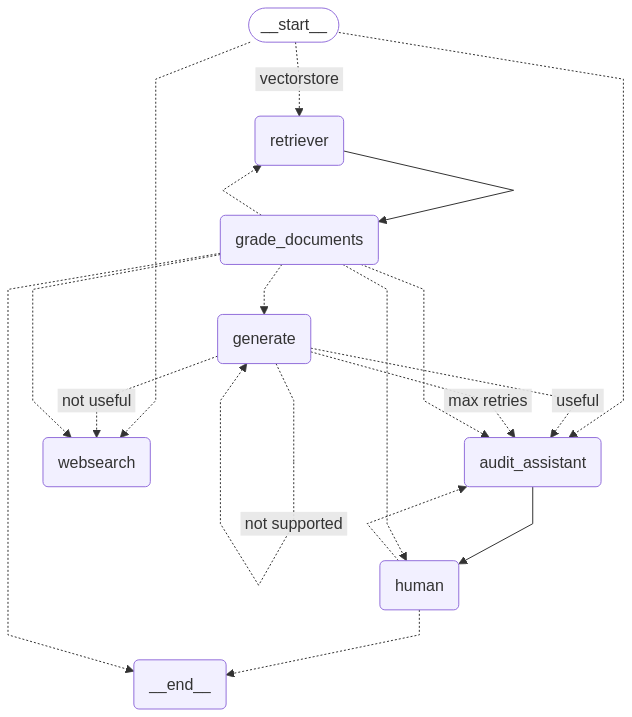

In [201]:
display(Image(chat_graph.get_graph().draw_mermaid_png()))

In [213]:
inputs = {"messages": ["what is FSDH Merchant Bank?"], "max_loops": 3}
for event in chat_graph.stream(inputs, stream_mode="values"):
    print(event)

content='what is FSDH Merchant Bank?' additional_kwargs={} response_metadata={} id='d66150e7-54a8-4105-86ea-af8d00bf8c34'
---ROUTING---


ValidationError: 15 validation errors for HumanMessage
content.str
  Input should be a valid string [type=string_type, input_value=HumanMessage(content='wha...4105-86ea-af8d00bf8c34'), input_type=HumanMessage]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].0.str
  Input should be a valid string [type=string_type, input_value=('content', 'what is FSDH Merchant Bank?'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].0.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('content', 'what is FSDH Merchant Bank?'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].1.str
  Input should be a valid string [type=string_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].1.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].2.str
  Input should be a valid string [type=string_type, input_value=('response_metadata', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].2.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('response_metadata', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].3.str
  Input should be a valid string [type=string_type, input_value=('type', 'human'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].3.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('type', 'human'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].4.str
  Input should be a valid string [type=string_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].4.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].5.str
  Input should be a valid string [type=string_type, input_value=('id', 'd66150e7-54a8-4105-86ea-af8d00bf8c34'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].5.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('id', 'd66150e7-54a8-4105-86ea-af8d00bf8c34'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].6.str
  Input should be a valid string [type=string_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].6.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type

In [185]:
config = {"recursion_limit": 1000}
chat_graph.invoke({"messages": []}, config)

---ROUTING---


ValidationError: 21 validation errors for HumanMessage
content.str
  Input should be a valid string [type=string_type, input_value=AIMessage(content="Welcom...4fb8-93c3-d69fa75a0b02'), input_type=AIMessage]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].0.str
  Input should be a valid string [type=string_type, input_value=('content', "Welcome to t... end the conversation."), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].0.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('content', "Welcome to t... end the conversation."), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].1.str
  Input should be a valid string [type=string_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].1.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('additional_kwargs', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].2.str
  Input should be a valid string [type=string_type, input_value=('response_metadata', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].2.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('response_metadata', {}), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].3.str
  Input should be a valid string [type=string_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].3.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('type', 'ai'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].4.str
  Input should be a valid string [type=string_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].4.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('name', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].5.str
  Input should be a valid string [type=string_type, input_value=('id', '32891b23-11fe-4fb8-93c3-d69fa75a0b02'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].5.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('id', '32891b23-11fe-4fb8-93c3-d69fa75a0b02'), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].6.str
  Input should be a valid string [type=string_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].6.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('example', False), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].7.str
  Input should be a valid string [type=string_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].7.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].8.str
  Input should be a valid string [type=string_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].8.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('invalid_tool_calls', []), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type
content.list[union[str,dict[any,any]]].9.str
  Input should be a valid string [type=string_type, input_value=('usage_metadata', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
content.list[union[str,dict[any,any]]].9.dict[any,any]
  Input should be a valid dictionary [type=dict_type, input_value=('usage_metadata', None), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.11/v/dict_type